## 5장 서포트 벡터 머신

### 주요 내용
- 선형 SVM 분류
- 비선형 SVM 분류: 커널 트릭
- SVM 회귀
- SVM 이론

참고: 핵심 설명과 코드는 🔑로 표시되었으며 굳이 알아둘 필요가 없는 코드는 ✋로 표시되었다.


### 기본 설정
- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)


In [3]:

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 5.1 선형 SVM 분류 (p. 205)

그림 5-1 코드 (p. 206)
붓꽃 데이터에서 세토사(setosa) 품종과 버시컬러(versicolor) 품종만을 대상으로 선형 SVM 분류기(하드 마진 분류)를 학습시킨다.

In [4]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]                      # 특성 2개(꽃잎 길이, 꽃잎 너비)
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)      # 세토사와 버시컬러만 대상임.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# 선형 SVM 분류 모델
svm_clf = SVC(kernel="linear", 
             )  # C=무한대. 즉, 하드 마진 분류임.
svm_clf.fit(X, y)

SVC(kernel='linear')

아래 함수는 SVM 분류 모델로 학습된 내용을 그래프로 보여준다. 3개의 인자가 요구된다.

- svm_clf: 학습된 SVM 모델
- xmin, xmax: 그래프의 x축 좌표 구간

In [5]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]            # 결정경계 파라미터(w0, w1)
    b = svm_clf.intercept_[0]       # 절편(b)

    # 결정경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]    # 결정경계

    margin = 1/w[1]                                 # 마진(도로 폭)
    gutter_up = decision_boundary + margin          # 도로 경계(윗쪽)
    gutter_down = decision_boundary - margin        # 도로 경계(아랫쪽)

    # 서포트 벡터 표시
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    
    # 결정경계 및 도로 경계 그리기
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

아래 코드는 그림 5-1을 그린다.

- 왼편 그림: 일반적인 선형 분류의 단점을 보여주기 위해 일부러 선분을 극단적으로 그림.
- 오른편 그림: SVM (하드 마진) 분류의 장점을 잘 보여줌.

그림 저장: large_margin_classification_plot


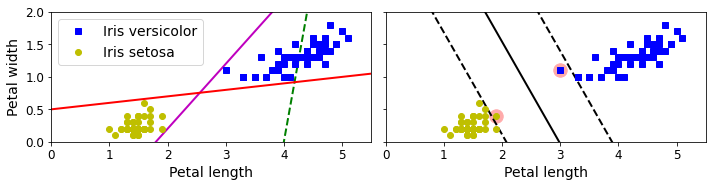

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼쪽 그림
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

# 오른쪽 그림
plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()


#### 그림 5-2 코드 (p. 206)

아래 코드는 SVM이 특성 축척에 민감하다는 것을 보여주는 그림을 그려준다.

- 학습 데이터: 작위적으로 지정된 데이터 네 개 (특성 수는 2)
- 왼편 그림: 축척 조정 없음
- 오른편 그림: 축척 조정 전처리 추가

그림 저장: sensitivity_to_feature_scales_plot


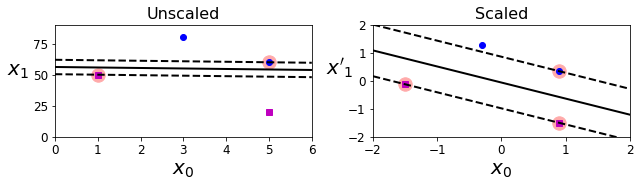

In [7]:
# 학습 데이터 4개
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

# SVM 훈련
svm_clf = SVC(kernel="linear", C=100)   # 마진 조금 허용
svm_clf.fit(Xs, ys)

# 왼편 그림
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# 오른편 그림(축척 조정 전처리 사용)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

### 5.1.1 소프트 마진 분류 (p.206)

## 그림 5-3 코드 (p. 207)
아래 코드는 그림 5-1에서 사용한 붓꽃 데이터에 이상치 두 개를 추가할 때 SVM을 이용한 하드 마진 분류의 문제를 보여준다.

- 왼편 그림에 사용된 이상치의 꽃잎 길이/너비 특성: [3.4, 1.3]
- 오른편 그림에 사용된 이상치의 꽃잎 길이/너비 특성: [3.2, 0.8]

In [8]:
# 이상치 두 개
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

# 왼편 그림 훈련 세트
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

# 오른편 그림 훈련 세트
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

그림 저장: sensitivity_to_outliers_plot


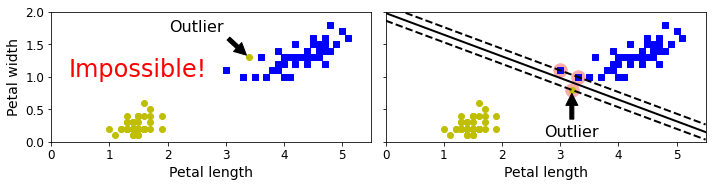

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 그림: 하드 마진 분류 불가능
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

# 오른편 그림: 좋지 않은 하드 마진 분류. SVC와 linear 커널 사용.
svm_clf2 = SVC(kernel="linear", C=10**9)     # 마진 매우 작게 설정
svm_clf2.fit(Xo2, yo2)

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

### 선형 소프트 마진 분류 학습
아래 코드는 마진 오류를 허용하는, 즉 소프트 마진 분류를 지원하는 선형 SVM 학습법을 보여준다.

- LinearSVC: 선형 SVM 이진 분류 모델.
    - C=1: 기본값
    -  logss=hinge: hinge 손실함수 사용. 기본값은 squared_hinge, hinge 손실함수의 제곱이며 미분가능.
    - dual=True: 쌍대성(duality) 이용 여부. True가 기본. 하지만 특성 수가 샘플 수보다 작을 때는 False 권장.
    
    
    
- 훈련 세트: 붓꽃 데이터 전체
- 타깃: 버지니카 품종 여부 (음성 0, 양성 1)
- 표준화 축척 조정 전처리 사용


주의사항: LinearSVC 모델의 C에 의한 규제에 편향(절편)도 포함된다. 따라서 평균을 빼서 0으로 편향을 없애는 것이 중요하다. 하지만 표준화 축척 조정을 하면 자연스럽게 해결된다.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]                   # 특성: 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # 타깃: 버지니카(Iris-Verginica) 품종 여부

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

[5.5, 1.7] 특성을 갖는 붓꽃에 대한 예측은 양성, 즉 버지니카 품종이다.

In [11]:
svm_clf.predict([[5.5, 1.7]])

array([1.])